# Actividad Semanal -- 7 Regresiones y K means

**Maestría en Inteligencia Artificial Aplicada**

**Curso:** Ciencia y analítica de datos (Gpo 10)

**Tecnológico de Monterrey**

**Fecha:** 09 de noviembre del 2022

**Profesor:** Jobish Vallikavungal Devassia

**Nombre del estudiante:** Daniela Parra García

**Matrícula:** A01633687

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

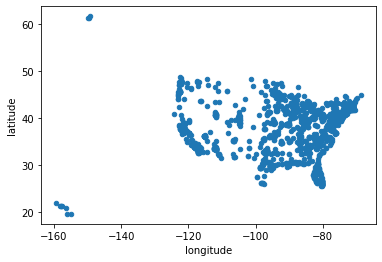

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [12]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,889953.0,Oceania,Fiji,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,58005463.0,Africa,Tanzania,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253.0,Africa,W. Sahara,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,37589262.0,North America,Canada,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,328239523.0,North America,United States of America,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

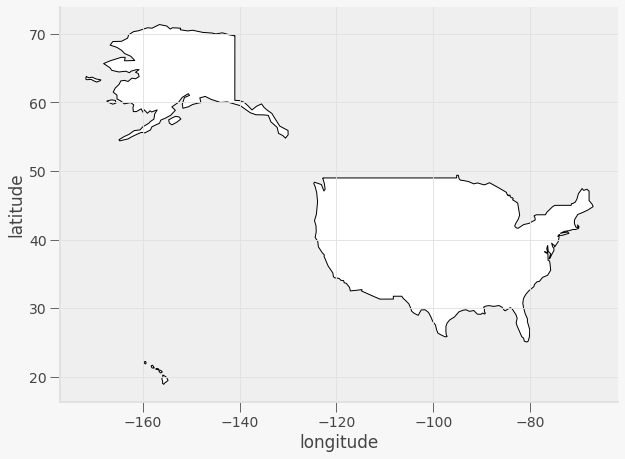

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

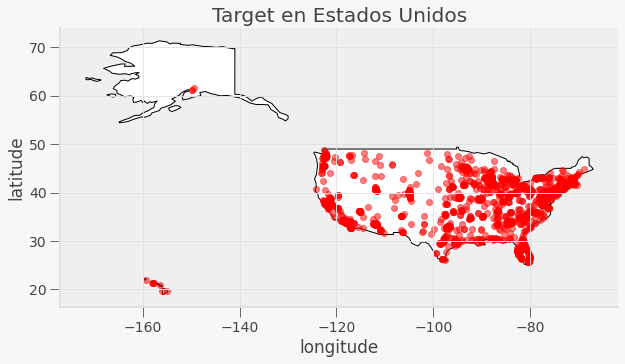

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

### Encuentra las latitudes y longitudes de los almacenes.

In [16]:
#tu codigo aquí

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50)
X = latlong
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [19]:
centers = kmeans.cluster_centers_
centers

array([[  45.07937138,  -93.31184112],
       [  33.8302684 , -117.84085912],
       [  38.58606251,  -77.09116847],
       [  36.31095624,  -97.23535007],
       [  28.6257409 ,  -81.82234486],
       [  47.55169935, -122.2134304 ],
       [  20.94542771, -157.31225085],
       [  41.83578902,  -87.82154145],
       [  31.21398636,  -84.66710414],
       [  39.89245041, -105.10801519],
       [  42.49592535,  -71.28495321],
       [  61.31264473, -149.6767927 ],
       [  30.74476061,  -90.75930143],
       [  37.87657742, -121.51443659],
       [  41.04490911,  -73.76792827],
       [  42.4962818 ,  -83.9327922 ],
       [  39.13032165,  -85.29996929],
       [  41.10665394, -111.98325574],
       [  33.29453293, -111.84821456],
       [  29.89042788,  -95.36279204],
       [  34.53329802,  -81.18683885],
       [  36.46853662,  -86.85404377],
       [  41.51113335,  -96.51436038],
       [  35.0363765 ,  -93.2051075 ],
       [  40.11074231,  -75.35353394],
       [  46.33066113, -1

In [20]:
dfCenters = pd.DataFrame()
dfCenters["Coordinates"] = list(zip(centers[:, 1], centers[:, 0]))
dfCenters["Coordinates"] = dfCenters["Coordinates"].apply(Point)
dfCenters.head()

,Coordinates
0,POINT (-93.31184112027027 45.07937137567568)
1,POINT (-117.84085911707318 33.830268403252035)
2,POINT (-77.09116847254901 38.586062510784316)
3,POINT (-97.23535006666667 36.310956242857145)
4,POINT (-81.82234486056338 28.625740895774644)


In [21]:
gdfCenter = gpd.GeoDataFrame(dfCenters, geometry="Coordinates")
gdfCenter.head()

,Coordinates
0,POINT (-93.31184 45.07937)
1,POINT (-117.84086 33.83027)
2,POINT (-77.09117 38.58606)
3,POINT (-97.23535 36.31096)
4,POINT (-81.82234 28.62574)


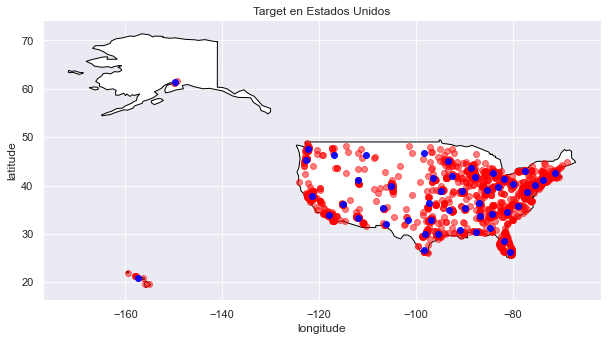

In [22]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)
gdfCenter.plot(ax = gax, color='blue', alpha=0.9)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()



In [23]:
! pip install geopy

In [24]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")
States = []

dfCenterLatLog = pd.DataFrame()
dfCenterLatLog["Coordinates"] = list(zip(centers[:, 0], centers[:, 1]))
#print(dfCenterLatLog.head())

for latlog in dfCenterLatLog["Coordinates"]:
    #print(latlog)

    location = geolocator.reverse(str(latlog[0])+","+str(latlog[1]))

    # Display
    #print(location.raw['address'].get('country', ''))
    #print(location.raw['address'].get('state', ''))
    States.append(location.raw['address'].get('state', ''))
 
print(len(States))
print('DONE')

50
DONE


Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?

In [25]:
#Suma de distancias cuadradas de los target en Estados Unidos a su Almacen más cercano
kmeans.inertia_

1801.9154457663349

Suma de distancias cuadradas de los Target en Estados Unidos a su Almacen más cercano: 1801.915


In [26]:
mapOfStates = {}
print(len(States))
for state in States:
    if(state==''):
        mapOfStates['Hawaii'] = str(States.count(state) + 1)
    else:
        mapOfStates[state] = str(States.count(state)) 
        
print(mapOfStates)

50
{'Minnesota': '1', 'California': '2', 'Maryland': '1', 'Oklahoma': '1', 'Florida': '2', 'Washington': '1', 'Hawaii': '2', 'Illinois': '1', 'Georgia': '2', 'Colorado': '1', 'Massachusetts': '1', 'Alaska': '1', 'Louisiana': '1', 'New York': '2', 'Michigan': '1', 'Indiana': '1', 'Utah': '1', 'Arizona': '1', 'Texas': '5', 'South Carolina': '1', 'Tennessee': '2', 'Nebraska': '1', 'Arkansas': '1', 'Pennsylvania': '2', 'Idaho': '1', 'New Mexico': '2', 'Missouri': '1', 'Montana': '1', 'Kansas': '1', 'Nevada': '1', 'Alabama': '2', 'Ohio': '2', 'Oregon': '1', 'North Carolina': '1', 'Iowa': '1', 'North Dakota': '1', 'Wisconsin': '1'}


Los estados en los que se tendrán almacenes son los anteriores, como se muestra, en Texas se tendrán 5 debido a la gran cantidad de consumo en esa zona.

¿Cómo elegiste el número de almacenes?<br>
Elegí tener 50 almacenes debido a que Estados Unidos cuenta con 50 estados contando a Alaska y Hawaii, y debido a que Target es una gran empresa de negocios dentro de este País, se necesitaría al menos un almacen por cada uno de estos estados.

¿Qué librerías nos pueden ayudar a graficar este tipo de datos?

Algunas de las librerias que nos pueden ayudar para graficar estos tipos de datos geográficos son:

-Folium<br>
Ayuda a crear mapas creando un archivo de HTML para crearlo, es bastante interactiva y, en mi opinión, es super sencilla de utilizar, con solo importarla y una línea en la que se le mandan las coordenadas de una localización te crea un mapa centrado en en ese punto con una buena visualización del área de alrededor.

-GeoPy<br>
Es de bastante utilidad para localizar coordenadas desde direcciones o nombres de instituciones o negocios, además como ya observamos anteriormente, es de gran utilidad para poder encontrar información de ubicaciones, como en el caso anterior en el cual con las coordenadas encontramos los estados y países de estas ubicaciones.

-Cartopy<br>
Esta librería apoya mucho en la creación de mapas con calidad de publicación, no son tan interactivos como los de Folium, pero son de igual manera faciles de implementar, además de que tiene una gran capacidad para transformar lineas, vectores e imagenes para poderlas mostrar al usuario.


¿Consideras importante que se grafique en un mapa?, ¿por qué?<br>
En lo personal, creo que para estos tipos de datos es muy importante graficar este tipo de datos debido a que este tipo de visualización es de gran ayuda para poder comprender y analizar de una manera más adecuada todos los datos que se tienen y que se van obteniendo.

Conclusiones<br>
Para poder tener un análisis correcto de la informaci+on con la que se trabajará se debe de elegir la visualización indicada que más apoye al análisis correcto de la información, ya que si se eliige un tipo de visualización que no es el adecuado se pueden perder datos que se creían no necesarios. En los casos en los que tenemos cooredenadas, en mi opinión, lo más adecuado es primeramente graficar esas locaciones en base a un mapa para tener un mejor entendimiento de todos los datos, como se vino trabajando en este Notebook.


In [27]:
#ejemplo de Folium
import folium
m = folium.Map(location=[20.73292915083666, -103.45403655424958])
m

In [28]:
#ejemplo de GeoPy
location = geolocator.geocode("Tec de Monterrey Campus Guadalajara") 
print(location.address) 
print((location.latitude, location.longitude))

Tec de Monterrey campus Guadalajara, Avenida Aviación, Sol Real, San Juan de Ocotán, Zapopan, Jalisco, 45201, México
(20.7347699, -103.45507909147551)
